# Predicting The Decision Outcome of Food Safety Inspection
**A personal project of Azizha Zeinita**

* **Project Goals**:

Predicting the decision outcome of food safety inspection based on the inspectors’ comments in Chicago Food Inspection dataset using multinomial classification models and select the most robust one.

* **Data Source**:

Chicago Data Portal - Fodd inspections of restaurants and other food establishments in Chicago from January 1, 2010 to August 4, 2022. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program. https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5


* **Methods**:

1. Regular Expression (Regex)
2. Tokenization using nltk.tokenize
3. Classification Models - Multinomial:
    * Gradient Boosting
    * XGBoost
    * Logistic Regression
    * Naive Bayes

In [3]:
import pandas as pd
import warnings
import numpy as np
import re
import nltk as nltk
import nltk.corpus  
from nltk.text import Text

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
import wordcloud

import seaborn as sns
import matplotlib.pyplot as plt

import sys
warnings.filterwarnings('ignore')
import os
# os.getcwd()

## 1. Data Preparation

### 1.1. Load The Dataset

In [2]:
df = pd.read_csv('/Users/azizhazeinita/Project/NLP/Food_Inspections.csv')
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2561879,SOLITA,SOLITA,2857386.0,Restaurant,Risk 3 (Low),431 N WELLS ST,CHICAGO,IL,60654.0,08/09/2022,License,Pass,NaN,41.890025,-87.633882,"(-87.63388240330882, 41.89002468212031)"
1,2559417,CHEZ JOEL,CHEZ JOEL,32359.0,Restaurant,Risk 1 (High),1119 W TAYLOR ST,CHICAGO,IL,60607.0,06/15/2022,Non-Inspection,No Entry,NaN,41.869332,-87.655107,"(-87.65510678669794, 41.86933227916697)"
2,2559999,ROJO GUSANO,ROJO GUSANO,1305286.0,Restaurant,Risk 1 (High),3830 W LAWRENCE AVE,CHICAGO,IL,60625.0,06/28/2022,Canvass,Out of Business,NaN,41.968390,-87.724448,"(-87.72444785924317, 41.968390431264375)"
3,2554552,HOST INTERNATIONAL B05,LA TAPENADE (T1-B5),34203.0,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,04/20/2022,Canvass,Pass,NaN,42.008536,-87.914428,"(-87.91442843927047, 42.008536400868735)"
4,2553925,LITTLE HARVARD ACADEMY,LITTLE HARVARD ACADEMY,2215573.0,Daycare (2 - 6 Years),Risk 1 (High),2708 W PETERSON AVE,CHICAGO,IL,60659.0,04/05/2022,Canvass,Out of Business,NaN,41.990564,-87.697365,"(-87.69736479750581, 41.99056361928264)"


### 1.2. Checking Initial Dataset of Medel's Feature and Target

In [9]:
# Initial Data (Before Cleaning) of Feature Variable
df['Violations'][20]

'9. NO BARE HAND CONTACT WITH RTE FOOD OR A PRE-APPROVED ALTERNATIVE PROCEDURE PROPERLY ALLOWED - Comments: OBSERVED THE EMPLOYEE SLICING FRESH TOMATOES AND ASSEMBLING READY-TO-EAT LETTUCE, ONION, AND TOMATOES FOR A SALAD WITH BARE HANDS. REVIEWED NO BARE HAND CONTACT WITH READY-TO-EAT FOODS. ALL FOODS DISCARDED. PRIORITY VIOLATION 7-38-010 CITATION ISSUED. | 15. FOOD SEPARATED AND PROTECTED - Comments: OBSERVED RAW CHICKEN ON THE COOK LINE CUTTING BOARD DIRECTLY NEXT TO FRESH READY-TO-EAT TOMATOES AND AVOCADO THAT WERE BEING SLICED AND PREPARED. ALSO OBSERVED WERE RAW EGGS STORED DIRECTLY ON TOP OF READY-TO-EAT TORTILLAS, ROASTED PEPPERS, AND RAW ONIONS IN THE TOP REFRIGERATION AREA OF THE COOKS LINE COOLER. ALL FOODS WERE REMOVED AND DISCARDED. PRIORITY VIOLATION 7-38-005 CITATION ISSUED. | 23. PROPER DATE MARKING AND DISPOSITION - Comments: OBSERVED ALL PREPARED TCS READY TO EAT FOODS THROUGHOUT ALL COOLERS NOT LABELED. NO EXPIRATION DATES OR PREP DATES. FOOD SUCH AS COOKED RICE, FL

In [8]:
# Data of Target Variable
df['Results']

0                    Pass
1                No Entry
2         Out of Business
3                    Pass
4         Out of Business
               ...       
240228               Pass
240229               Pass
240230               Fail
240231               Pass
240232               Pass
Name: Results, Length: 240233, dtype: object

### 1.3. Cleanig The Text in Feature Data Using Regex

In [3]:
# df_fail = df[df.Results=='Fail']
df_all = df.copy()

# Drop Null Value in All Columns Based On The Null Value In Column 'Violations'
df_clean = df_all.dropna(subset=['Violations'])

# Remove Comments
a = df_clean.Violations.apply(lambda x: re.sub(r'\s?\-\s+Comments.*?\|','',x))

# Remove The Last Comment
b = a.apply(lambda x: re.sub(r'\s?\-\s+Comments.*','',x))

# Remove Regulation Code
c = b.apply(lambda x: re.sub(r'\s\d+','', str(x)))

# Remove Regulation Code In The Beginning of Paragraphs
d = c.apply(lambda x: re.sub(r'^\d+\W+ | ^\d?\.', '', x))

# Make Sure To Remove All '|'
e = d.apply(lambda x: re.sub(r'([\|])','', str(x)))

# Make Sure To Remove All Space At The End of Sentences
f = e.apply(lambda x: re.sub('([\w]) ([.])', r'\1\2', str(x)))

# Make Sure To Remove All Space At The Beginning of Sentences
g = f.apply(lambda x: re.sub(r'\^s','', str(x)))

# Remove Space After Dots, So It Can Be Easy To Split (Based On Dots)
h = g.apply(lambda x: re.sub('([.]) ([\w])', r'\1\2', str(x)))

# Replace : to be ' ' and ; to be .
desc = h.str.replace(r'\;', '.', regex=True)

# Store Description-Only Into DataFrame
df_clean['Description'] = desc.tolist()

In [4]:
df_clean['Description']

20        NO BARE HAND CONTACT WITH RTE FOOD OR A PRE-AP...
33        PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN
58                    WIPING CLOTHS: PROPERLY USED & STORED
71                FOOD PROPERLY LABELED. ORIGINAL CONTAINER
84              PLUMBING INSTALLED. PROPER BACKFLOW DEVICES
                                ...                        
240225    SANITIZING RINSE FOR EQUIPMENT AND UTENSILS:  ...
240226    SANITIZING RINSE FOR EQUIPMENT AND UTENSILS:  ...
240227    FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: ...
240230    NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS...
240231    FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS C...
Name: Description, Length: 175259, dtype: object

## 2. Data Preprocessing

### 2.1. Convert 'Results' Value to Numeric Category

In [5]:
# Find What Are The Category
df_clean['Results'].unique()

array(['Fail', 'Pass', 'Pass w/ Conditions', 'No Entry', 'Not Ready',
       'Out of Business'], dtype=object)

In [6]:
# convert label to a binary numerical variable
df_clean['Results_flag'] = df_clean.Results.map({'Fail':0, 'Pass':1, 'No Entry':2, 'Not Ready':3,
                                                 'Out of Business':4, 'Pass w/ Conditions':5})


In [7]:
# Make a New Dataframe for Modeling
df_model = df_clean[['Description', 'Results', 'Results_flag']]
df_model.head()

,Description,Results,Results_flag
20,NO BARE HAND CONTACT WITH RTE FOOD OR A PRE-AP...,Fail,0
33,"PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN",Pass,1
58,WIPING CLOTHS: PROPERLY USED & STORED,Pass,1
71,FOOD PROPERLY LABELED. ORIGINAL CONTAINER,Pass,1
84,PLUMBING INSTALLED. PROPER BACKFLOW DEVICES,Pass,1


### 2.2. Define Train and Test Data of X & y

In [8]:
X = df_model['Description']
y = df_model['Results_flag']

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (175259,)
y Shape: (175259,)


In [9]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (140207,) y_train: (140207,)
Testing records, X_test: (35052,) y_test: (35052,)


### 2.3. Vectorizing The Dataset

In [10]:
# instantiate the vectorizer
vect = CountVectorizer(max_df=0.5)

# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)

In [11]:
X_train_dtm

<140207x350 sparse matrix of type '<class 'numpy.int64'>'
	with 2932973 stored elements in Compressed Sparse Row format>

In [12]:
X_test_dtm

<35052x350 sparse matrix of type '<class 'numpy.int64'>'
	with 731834 stored elements in Compressed Sparse Row format>

### 2.4. Normalize Dataset

In [13]:
# Normalization Using Scaling

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_dtm)
X_test_scaled = scaler.transform(X_test_dtm)

## 3. Modeling - Multinomial

### 3.1. Naive Bayes Model

In [14]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

# train and time the model using X_train_dtm
%time nb.fit(X_train_scaled, y_train)


CPU times: user 57.7 ms, sys: 7.83 ms, total: 65.6 ms
Wall time: 79.4 ms


MultinomialNB()

In [15]:
# make class predictions for X_test_dtm
y_train_pred_nb = nb.predict(X_train_scaled)

# calculate accuracy of class predictions
acc_train_nb = metrics.accuracy_score(y_train, y_train_pred_nb)
print(f"Train Accuracy: {acc_train_nb * 100:.1f}%")

Train Accuracy: 85.4%


In [16]:
# make class predictions for X_test_dtm
y_test_pred_nb = nb.predict(X_test_scaled)

# calculate accuracy of class predictions
acc_test_nb = metrics.accuracy_score(y_test, y_test_pred_nb)
print(f"Test Accuracy: {acc_test_nb * 100:.1f}%")

Test Accuracy: 85.5%


In [17]:
# calculate precision and recall
clas_report_nb = classification_report(y_test, y_test_pred_nb)
print(clas_report_nb)

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      8678
           1       0.95      0.95      0.95     19024
           2       0.00      0.00      0.00       123
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         6
           5       0.70      0.79      0.74      7206

    accuracy                           0.86     35052
   macro avg       0.41      0.41      0.41     35052
weighted avg       0.86      0.86      0.85     35052



<AxesSubplot:>

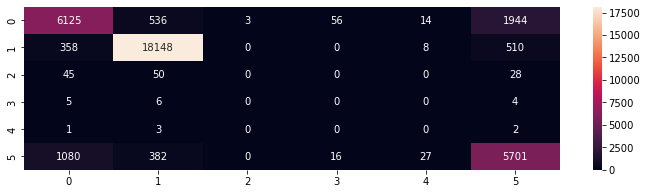

In [18]:
# calculate the confusion matrix
conf_metric_nb = metrics.confusion_matrix(y_test, y_test_pred_nb)

fig, ax = plt.subplots(figsize=(12,3)) 
sns.heatmap(conf_metric_nb, annot=True, fmt=".0f", ax=ax)

In [19]:
# Most and Least Important Features

clf = nb

feature_names_nb = vect.get_feature_names()
coefs_with_fns_nb = zip(feature_names_nb, clf.coef_[0])

coefs_with_fns_df_nb = pd.DataFrame(coefs_with_fns_nb,
                    columns=['feature', 'coefficient'])

coefs_with_fns_df_nb.sort_values(by='coefficient', ascending=False, inplace=True)
print('The Most Important Features:\n')
print(coefs_with_fns_df_nb.head(10))
print('\n')
print('The Least Important Features:\n')
coefs_with_fns_df_nb.sort_values(by='coefficient', ascending=True, inplace=True)
print(coefs_with_fns_df_nb.head(10))

The Most Important Features:

        feature  coefficient
229   protected    -4.377329
258      rodent    -4.458608
314          to    -4.529537
25    available    -4.542718
146      insect    -4.546936
105    evidence    -4.553151
311         the    -4.554913
349     written    -4.590206
276       shall    -4.590206
150  inspectors    -4.590206


The Least Important Features:

         feature  coefficient
5      additives   -12.974934
184      offered   -12.974934
225   prohibited   -12.974934
198  pasteurized   -12.569469
326    unwrapped   -12.281787
344        where   -12.281787
62        cooked   -12.281787
120       fruits   -12.281787
205        plant   -12.281787
330   vegetables   -12.281787


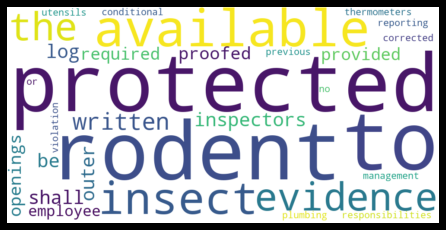

In [66]:
# Wordcloud of The Most Important Features:
top_features_df = coefs_with_fns_df_nb.copy()
top_features_df['coefficient'] = top_features_df['coefficient']*(10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (6, 3),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

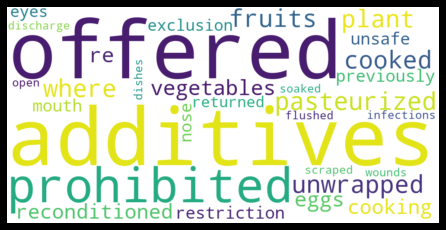

In [67]:
# Wordcloud of The Least Important Features:
top_features_df = coefs_with_fns_df_nb.copy()
top_features_df['coefficient'] = top_features_df['coefficient']*(-10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (6, 3),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 3.2. Logistic Regression

In [20]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=1000, C=10, solver='saga')
# train the model using X_train_dtm
%time logreg.fit(X_train_scaled, y_train)

CPU times: user 2min 3s, sys: 2.12 s, total: 2min 5s
Wall time: 2min 20s


LogisticRegression(C=10, max_iter=1000, solver='saga')

In [21]:
# make class predictions for train dataset
y_train_pred_logreg = logreg.predict(X_train_scaled)
acc_train_logreg = metrics.accuracy_score(y_train, y_train_pred_logreg) * 100

# calculate accuracy of class predictions
print("Accuracy score (training): {0:.3f}".format(acc_train_logreg))

Accuracy score (training): 90.648


In [22]:
# make class predictions for test dataset
y_test_pred_logreg = logreg.predict(X_test_scaled)
acc_test_logreg = metrics.accuracy_score(y_test, y_test_pred_logreg) * 100

# calculate accuracy of class predictions
print("Accuracy score (testing): {0:.3f}".format(acc_test_logreg))

Accuracy score (testing): 90.660


In [23]:
# calculate precision and recall
clas_reposrt_logreg = classification_report(y_test, y_test_pred_logreg)
print(clas_reposrt_logreg)

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      8678
           1       0.96      0.99      0.97     19024
           2       0.00      0.00      0.00       123
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         6
           5       0.83      0.81      0.82      7206

    accuracy                           0.91     35052
   macro avg       0.44      0.44      0.44     35052
weighted avg       0.90      0.91      0.90     35052



<AxesSubplot:>

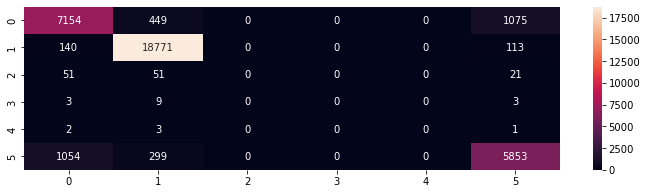

In [24]:
# calculate the confusion matrix
conf_metric_logreg = metrics.confusion_matrix(y_test, y_test_pred_logreg)

fig, ax = plt.subplots(figsize=(12,3)) 
sns.heatmap(conf_metric_logreg, annot=True, fmt=".0f", ax=ax)

In [25]:
# Most and Least Important Features

clf = logreg

feature_names_logreg = vect.get_feature_names()
coefs_with_fns_logreg = zip(feature_names_logreg, clf.coef_[0])

coefs_with_fns_df_logreg = pd.DataFrame(coefs_with_fns_logreg,
                    columns=['feature', 'coefficient'])

coefs_with_fns_df_logreg.sort_values(by='coefficient', ascending=False, inplace=True)
print('The Most Important Features:\n')
print(coefs_with_fns_df_logreg.head(10))
print('\n')
print('The Least Important Features:\n')
coefs_with_fns_df_logreg.sort_values(by='coefficient', ascending=True, inplace=True)
print(coefs_with_fns_df_logreg.head(10))

The Most Important Features:

          feature  coefficient
182        number     3.432343
61     convenient     3.314973
266     sanitized     2.881672
3      accessible     2.508760
229     protected     2.494445
47           cold     2.069340
6        adequate     2.029416
307  temperatures     1.999919
306   temperature     1.942237
179            no     1.884950


The Least Important Features:

           feature  coefficient
5        additives    -1.971703
205          plant    -1.487310
62          cooked    -1.487310
140            ice    -0.966138
281         single    -0.955323
217      prevented    -0.819319
58   contamination    -0.641256
224     processing    -0.556497
325         unsafe    -0.510152
219     previously    -0.510152


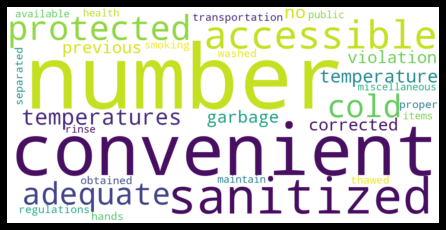

In [68]:
# Wordcloud of The Most Important Features:
top_features_df = coefs_with_fns_df_logreg.copy()
top_features_df['coefficient'] = top_features_df['coefficient']*(10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (6, 3),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

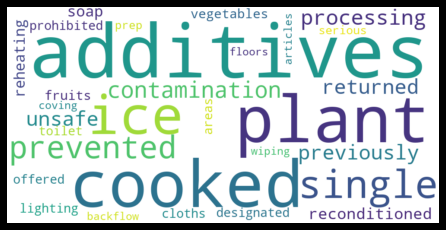

In [69]:
# Wordcloud of The Least Important Features:
top_features_df = coefs_with_fns_df_logreg.copy()
top_features_df['coefficient'] = top_features_df['coefficient']*(-10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (6, 3),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 3.3. Gradient Boosting Classifier

In [26]:
lr_list = [0.1, 0.25, 0.5, 0.75, 1]
y_train_pred_gb = []
y_test_pred_gb = []

for learning_rate in lr_list:
        gb = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_depth=6, random_state=1)
        gb.fit(X_train_scaled, y_train)

        # make class predictions for train dataset
        pred_train = gb.predict(X_train_scaled)
        y_train_pred_gb.append(pred_train)
        acc_train_gb = round(metrics.accuracy_score(y_train, pred_train) * 100, 3)
        
        # make class predictions for test dataset
        pred_test = gb.predict(X_test_scaled)
        y_test_pred_gb.append(pred_test)
        acc_test_gb = round(metrics.accuracy_score(y_test, pred_test) * 100, 3)

        # calculate accuracy of class predictions  
        print('Learning Rate: ', learning_rate)
        print("Accuracy score (training): ", acc_train_gb)
        print("Accuracy score (testing): ", acc_test_gb)
        

Learning Rate:  0.1
Accuracy score (training):  90.515
Accuracy score (testing):  90.389
Learning Rate:  0.25
Accuracy score (training):  91.302
Accuracy score (testing):  90.72
Learning Rate:  0.5
Accuracy score (training):  91.162
Accuracy score (testing):  90.4
Learning Rate:  0.75
Accuracy score (training):  90.82
Accuracy score (testing):  90.089
Learning Rate:  1
Accuracy score (training):  10.089
Accuracy score (testing):  9.862


* The best accuracy score in training and testing dataset is the model using **learning rate 0.25**, with **accuracy score (training): 91.302** and **accuracy score (testing): 90.72**

In [41]:
# calculate precision and recall
clas_report_gb = classification_report(y_test, y_test_pred_gb[1])
print(clas_report_gb)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      8678
           1       0.96      0.99      0.97     19024
           2       0.00      0.00      0.00       123
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         6
           5       0.85      0.79      0.82      7206

    accuracy                           0.91     35052
   macro avg       0.44      0.44      0.44     35052
weighted avg       0.90      0.91      0.90     35052



<AxesSubplot:>

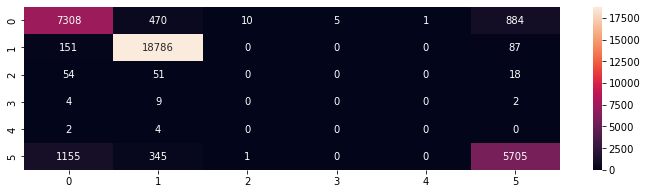

In [28]:
# calculate the confusion matrix
conf_metric_gb = metrics.confusion_matrix(y_test, y_test_pred_gb[1])

fig, ax = plt.subplots(figsize=(12,3)) 
sns.heatmap(conf_metric_gb, annot=True, fmt=".0f", ax=ax)

In [29]:
# Most and Least Important Features

clf = gb

feature_names_gb = vect.get_feature_names()
coefs_with_fns_gb = zip(feature_names_gb, clf.feature_importances_)

coefs_with_fns_df_gb = pd.DataFrame(coefs_with_fns_gb,columns=['feature', 'coefficient'])

coefs_with_fns_df_gb.sort_values(by='coefficient', ascending=False, inplace=True)
print('The Most Important Features:\n')
print(coefs_with_fns_df_gb.head(10))
print('\n')
print('The Least Important Features:\n')
coefs_with_fns_df_gb.sort_values(by='coefficient', ascending=True, inplace=True)
print(coefs_with_fns_df_gb.head(10))

The Most Important Features:

         feature  coefficient
314           to     0.278802
3     accessible     0.072210
208  potentially     0.042222
116          for     0.039314
274      service     0.037573
258       rodent     0.031475
333    violation     0.026034
45        cloths     0.025179
84    dispensing     0.022787
66     corrected     0.020682


The Least Important Features:

           feature  coefficient
290          sores          0.0
239        records          0.0
63         cooking          0.0
180           nose          0.0
225     prohibited          0.0
5        additives          0.0
176          mouth          0.0
184        offered          0.0
326      unwrapped          0.0
238  reconditioned          0.0


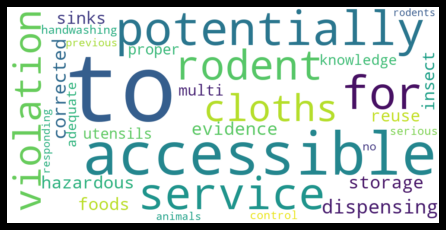

In [70]:
# Wordcloud of The Most Important Features:
top_features_df = coefs_with_fns_df_gb.copy()
top_features_df['coefficient'] = top_features_df['coefficient']*(10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (6, 3),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

* The Least Important Features' coefficients are zero, it can't be applied to wordcloud_obj.generate_from_frequencies(data) because it will give error of 'float division by zero'

### 3.4. XGBoost

In [30]:
lr_list = [0.1, 0.25, 0.5, 0.75, 1]
y_train_pred_xgb = []
y_test_pred_xgb = []

for lr in lr_list:
    xgb = XGBClassifier(objective='multi:softmax', num_class=6, learning_rate=lr, max_depth=6, random_state=1)
    # Adding objective='multi:softmax' and num_class=6 to make multinomial model
    xgb.fit(X_train_scaled, y_train)
    
    # make class predictions for train dataset
    pred_train = xgb.predict(X_train_scaled)
    y_train_pred_xgb.append(pred_train)
    acc_train_xgb = round(metrics.accuracy_score(y_train, pred_train) * 100, 3)
        
    # make class predictions for test dataset
    pred_test = xgb.predict(X_test_scaled)
    y_test_pred_xgb.append(pred_test)
    acc_test_xgb = round(metrics.accuracy_score(y_test, pred_test) * 100, 3)

    # calculate accuracy of class predictions  
    print('Learning Rate: ', lr)
    print("Accuracy score (training): ", acc_train_xgb)
    print("Accuracy score (testing): ", acc_test_xgb) 
    

Learning Rate:  0.1
Accuracy score (training):  91.365
Accuracy score (testing):  90.919
Learning Rate:  0.25
Accuracy score (training):  92.095
Accuracy score (testing):  91.005
Learning Rate:  0.5
Accuracy score (training):  92.756
Accuracy score (testing):  90.908
Learning Rate:  0.75
Accuracy score (training):  93.256
Accuracy score (testing):  90.848
Learning Rate:  1
Accuracy score (training):  93.485
Accuracy score (testing):  90.577


* The most balance accuracy between train and test is model with Learning Rate:  0.25

In [48]:
# calculate precision and recall
clas_report_xgb = classification_report(y_test, y_test_pred_xgb[1])
print(clas_report_xgb)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      8678
           1       0.96      0.99      0.97     19024
           2       0.00      0.00      0.00       123
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         6
           5       0.86      0.80      0.83      7206

    accuracy                           0.91     35052
   macro avg       0.44      0.44      0.44     35052
weighted avg       0.90      0.91      0.91     35052



<AxesSubplot:>

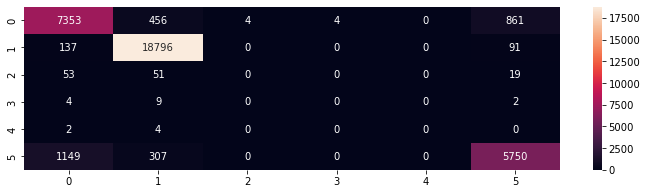

In [49]:
# calculate the confusion matrix
conf_metric_xgb = metrics.confusion_matrix(y_test, y_test_pred_xgb[1])

fig, ax = plt.subplots(figsize=(12,3)) 
sns.heatmap(conf_metric_xgb, annot=True, fmt=".0f", ax=ax)

In [55]:
# Most and Least Important Features

clf = xgb

feature_names_xgb = vect.get_feature_names()
coefs_with_fns_xgb = zip(feature_names_xgb, xgb.feature_importances_)

coefs_with_fns_df_xgb = pd.DataFrame(coefs_with_fns_xgb,
                    columns=['feature', 'coefficient'])

coefs_with_fns_df_xgb.sort_values(by='coefficient', ascending=False, inplace=True)
print('The Most Important Features:\n')
print(coefs_with_fns_df_xgb.head(10))
print('\n')
print('The Least Important Features:\n')
coefs_with_fns_df_xgb.sort_values(by='coefficient', ascending=True, inplace=True)
print(coefs_with_fns_df_xgb.head(10))

The Most Important Features:

       feature  coefficient
39        city     0.116525
258     rodent     0.107368
135  hazardous     0.079869
314         to     0.072045
66   corrected     0.062876
292     source     0.042987
296    storage     0.035361
26        back     0.031790
82        dish     0.029556
13     animals     0.026262


The Least Important Features:

        feature  coefficient
349     written          0.0
282       sinks          0.0
330  vegetables          0.0
303  suspension          0.0
280        sign          0.0
279    shielded          0.0
329    variance          0.0
278  shellstock          0.0
283   siphonage          0.0
276       shall          0.0


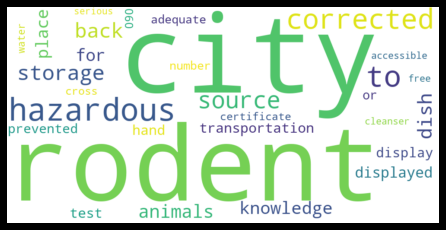

In [73]:
# Wordcloud of The Most Important Features:
top_features_df = coefs_with_fns_df_xgb.copy()
top_features_df['coefficient'] = top_features_df['coefficient']*(10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (6, 3),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

* The Least Important Features' coefficients are zero, it can't be applied to wordcloud_obj.generate_from_frequencies(data) because it will give error of 'float division by zero'

## 4. Model Comparison and Selecting The Most Robust One

In [75]:
df_combine = pd.DataFrame()
df_combine['Model'] = ['Naive Bayes','Logistic Regression','Gradient Boosting (best param)','XGBoost (best param)']
df_combine['Accuracy Score (Training)'] = [acc_train_nb*100, acc_train_logreg, 91.302, 92.095]
df_combine['Accuracy Score (Testing)'] = [acc_test_nb*100, acc_test_logreg, 90.72, 91.005] 

df_combine.sort_values(by='Accuracy Score (Testing)', ascending=False)

,Model,Accuracy Score (Training),Accuracy Score (Testing)
3,XGBoost (best param),92.095000,91.005000
2,Gradient Boosting (best param),91.302000,90.720000
1,Logistic Regression,90.648113,90.659591
0,Naive Bayes,85.439386,85.512952


* The most rubust model is XGBoost, with the accruacy score of training and testing dataset holding the highest place of all other models

## 5. Summary

**Summary:**
* The **best model's accuracy in training dataset** is XGBoost with Learning Rate 0.75 (93.485%). **However**, although the best model's accuracy in testing dataset is also XGBoost, but **it's in different parameter**, which is Learning Rate 0.25 (91.005%)
* Because of the difference between train' and test' accuracy is moving away, it can be an **indication of overvitting**. Thus, I recommend to choose **XGBoost model with Learning Rate 0.25 as the best model** (92.095% Training; 91.005% Testing) because it has the highest accuracy in testing dataset and the difference between training and testing accuracy is smaller
* The model can predict well on categories 'Fail':0, 'Pass':1, 'No Entry':2, and'Pass w/ Conditions':5, but **not for the others**

**Evaluation:**
* **In all models**, categories of 'No Entry':2, 'Not Ready':3,'Out of Business':4 **were not predicted at all**. It may happened because of the unbalanced dataset, as seen in the below calculation
* I've tried to normalize the data distribution using scaling, but it gived worst model accuracy. In the future, **additional data preprocessing methods** are needed to handle this kind of issue

In [89]:
# Show Data Distribution of Each Category
df_clean['Results'].value_counts()

Pass                  94930
Fail                  43153
Pass w/ Conditions    36474
No Entry                595
Not Ready                70
Out of Business          37
Name: Results, dtype: int64

* Number of X per each category of y is not equal